<a href="https://colab.research.google.com/github/Nid989/IDAML23_PROJECT/blob/main/data_exploration_and_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# NOTE: comment this when executing locally.
%cd "./drive/MyDrive/idaml1_project/"

/content/drive/MyDrive/idaml1_project


In [2]:
import random
import warnings
from collections import defaultdict
import yaml
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from typing import Literal, Dict, List

import sklearn
# preprocessing
from scipy import stats
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
# modeling techniques
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow import keras
from keras.initializers import GlorotNormal, GlorotUniform, Zeros
from keras.metrics import Accuracy, Precision, Recall
# evaluation
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

random.seed(42)
warnings.filterwarnings('ignore')

In [3]:
# ===================================== utility methods ===================================== #
def load_from_yaml(path_to_file: str):
    print(f"loading data from .yaml file @ {path_to_file}")
    with open(path_to_file) as file:
        _dict = yaml.safe_load(file)
    return _dict

# apply LabelEncoder to available `pd.Series` data
def initialize_label_encodings(column: pd.Series,
                               column_name: str):
    globals()[f"{column_name}_le"] = LabelEncoder()
    globals()[f"{column_name}_le"].fit(column[column.notnull()])
    return globals()[f"{column_name}_le"]

# calculate imputation values for each columns w/ missing values
imputation_method_types_ = Literal["mean", "median", "mode"]
def calculate_imputation_values(data: pd.DataFrame,
                                imputation_method: imputation_method_types_) -> Dict[str, float]:
    columns_w_missing_values = data.columns[data.isna().sum() > 0].values.tolist()
    output_dict = dict()
    if imputation_method == "mean":
        output_dict = {column: np.mean(data[column].dropna().values) for column in columns_w_missing_values}
    elif imputation_method == "mode":
        output_dict = {column: stats.mode(data[column].dropna().values)[0] for column in columns_w_missing_values}
    else:
        raise ValueError(f"No implementation for `imputation_method`: {imputation_method}")
    return output_dict

# featurization methods
# applying z-score scale to attributes
def apply_z_score_scaling(data: pd.Series,
                          column_name: str):
    globals()[f"{column_name}_standard_scaler"] = StandardScaler()
    transform_data = globals()[f"{column_name}_standard_scaler"].fit_transform(data)
    return transform_data, globals()[f"{column_name}_standard_scaler"]

# applying min-max scale to attributes
def apply_min_max_scaling(data: pd.Series,
                          column_name: str):
    globals()[f"{column_name}_minmax_scaler"] = MinMaxScaler()
    transform_data = globals()[f"{column_name}_minmax_scaler"].fit_transform(data)
    return transform_data, globals()[f"{column_name}_minmax_scaler"]

# applying log scale w/ base `b` to attributes
def apply_log_scaling(data: pd.Series,
                      column_name: str,
                      base_value: int=None):
    data = np.log1p(data.values)
    if base_value is not None:
        data = data / np.log1p(base_value)
    return data, {"base_value": base_value}

# applying one-hot encoding to catgorical data
def apply_one_hot_encoding(data: pd.Series,
                           column_name: str):
    globals()[f"{column_name}_label_binarizer"] = LabelBinarizer()
    transform_data = globals()[f"{column_name}_label_binarizer"].fit_transform(data)
    return transform_data, globals()[f"{column_name}_label_binarizer"]
# =========================================================================================== #

In [4]:
# ===================================== plots ===================================== #
def plot_roc_curve(y_true, y_pred_prob):
    """
    Plot the ROC curve for a binary classification problem.

    Parameters:
    - y_true: Array of true labels (0 or 1).
    - y_pred_prob: Array of predicted probabilities for the positive class (class 1).

    Returns:
    - None (plots the ROC curve).
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    # plt.show()

def plot_precision_recall_curve(y_true, y_pred_prob):
    """
    Plot the precision-recall curve for a binary classification problem.

    Parameters:
    - y_true: Array of true binary labels (0 or 1).
    - y_pred_prob: Array of predicted probabilities for the positive class (class 1).

    Returns:
    - None (plots the precision-recall curve).
    """
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    average_precision = average_precision_score(y_true, y_pred_prob)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    # plt.show()

def plot_confusion_matrix(cm_data: np.ndarray):
    """
    Plot confusion-matrix for a binary classification.

    Parameters:
    - cm_data: numpy.ndarray constituting of True Positve, False Postive,
        False Negative, True Negative
    Returns
    - None (plots the confusion-matrix as a heatmap)
    """
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_data,
                cmap='coolwarm',
                annot=True,
                fmt=".2f",
                square=True,
                linewidths=0.5,
                xticklabels=['Predicted <=50K', 'Predicted >=50K'],
                yticklabels=['Actual <=50K', 'Actual >=50K'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    # plt.show()
# ================================================================================= #

In [5]:
# ===================================== IncomeDataset ===================================== #
class IncomeDataset:
    def __init__(self,
                 config: dict,
                 exploration: bool=False):
        self.config = config
        # load and split `income` dataset
        self.load_data()
        if not exploration:
            # archive class-specific mappings
            self.archive_classwise_label_encodings()
            # encode `train` & `test` data split
            self.encode_data()
            # process and split data into `train` (self.X_train, self.y_train)
            # & `validation (self.X_test, self.y_test)`
            self.process_and_split_data()
            # apply imputation and scaling features to original 25k `test`
            # data split
            self.transform_orig_test_data()

    def load_data(self):
        columns = [
            # source columns
            "age", "employment_type", "weighting_factor", "level_of_education",
            "schooling_or_training_period", "marital_status", "employment_area",
            "partnership", "ethnicity", "gender", "gains_on_financial_assets",
            "losses_on_financial_assets", "weekly_working_time", "country_of_birth",
            # target columns
            "income"
        ]
        data = pd.read_csv(self.config["path_to_data_file"], names=columns)
        data = data.applymap(lambda item: item.strip() if isinstance(item, str) else item) # trim extra space from `str` elements
        data.replace("?", float("NaN"), inplace=True) # replace missing values w/ `float(NaN)`
        self.data = data
        # extract train & test split
        data_split_condition = data["income"].isna()
        self.train_data = data[~data_split_condition]
        self.test_data = data[data_split_condition].drop(columns=["income"], axis=1)

    def archive_classwise_label_encodings(self):
        """
        prepares `encoding_state_dict` to store class-specific LabelEncoder objects
        for mapping class values (`str`) to unique index (`int`)
        """
        if "country_of_birth" in self.train_data.columns.tolist():
            # apply binary categorization to the attribute `country_of_birth`
            self.data["country_of_birth"] = self.data["country_of_birth"].apply(lambda row: row if row == "United-States" else "Other")
            self.train_data["country_of_birth"] = self.train_data["country_of_birth"].apply(lambda row: row if row == "United-States" else "Other")
            self.test_data["country_of_birth"] = self.test_data["country_of_birth"].apply(lambda row: row if row == "United-States" else "Other")

        # classwise LabelEncoder archive
        self.encoding_state_dict = {column: initialize_label_encodings(column=self.data[column],
                                                                       column_name=column) \
                                    for column in self.data.columns if self.data[column].dtype == "object"}

    def encode_data(self):
        """
        apply classwise label-encoding mapping to `train` and `test` split
        of the `income` dataset.
        """
        def transform_column(column, label_encoder):
            # LabelEncoder mappings are applied to not `NaN` indices
            return pd.Series(
                label_encoder.transform(column[column.notnull()]),
                index=column[column.notnull()].index
            )

        columns_to_encode = self.train_data.select_dtypes(include=['object']).columns
        # encode; train-data split
        for column in columns_to_encode:
            self.train_data[column] = transform_column(self.train_data[column], self.encoding_state_dict[column])
        # encoder & ignore `income` column; test-data split
        for column in set(columns_to_encode) - set(["income"]):
            self.test_data[column] = transform_column(self.test_data[column], self.encoding_state_dict[column])

    def handle_missing_values(self):
        assert "object" not in self.train_data.dtypes.tolist(), \
            "train-data split consists of attributes w/ data-types as `object`"
        def impute_data(data, imputation_method):
            """
            apply imputation to the columns w/ missing values (i.e. `float(NaN)`)
            , utilize the `imputation_method` attribute from the configuration.
            """
            imputation_values_dict = calculate_imputation_values(
                data=data,
                imputation_method=imputation_method
            )
            for key, value in imputation_values_dict.items():
                data[key].fillna(value, inplace=True)
            return data, imputation_values_dict

        config_data = self.config["imputation_configuration"]
        if config_data["drop_nan"]:
            self.train_data.dropna(inplace=True)
        else:
            # strategy to calculate imputation values over inclusion of train + test
            # can be discarded due to inheritance of data attribute from test split
            # which should not overlap with the train split.
            data_copy = self.train_data.copy(deep=True)
            data_copy, imputation_values_dict = impute_data(data=data_copy,
                                                            imputation_method=config_data["imputation_method"])
            self.train_data = data_copy
            self.imputation_values_dict = imputation_values_dict

    def scale_data(self):
        data_copy = self.train_data.copy(deep=True)
        self.numerical_scaler_state_dict = {}
        self.categorical_scaler_state_dict = {}
        for column, scaling_strategy in self.config["scaling_configuration"].items():
            if column not in data_copy.columns.tolist():
                continue
            if scaling_strategy == "None":
                continue
            if "z_score" in scaling_strategy:
                data_copy[column], scaler = apply_z_score_scaling(data_copy[[column]], column_name=column)
                self.numerical_scaler_state_dict[column] = scaler
            elif "min_max" in scaling_strategy:
                data_copy[column], scaler = apply_min_max_scaling(data_copy[[column]], column_name=column)
                self.numerical_scaler_state_dict[column] = scaler
            elif "log" in scaling_strategy:
                base_value = None
                if isinstance(scaling_strategy, list):
                    _, base_value = scaling_strategy
                data_copy[column], scaler = apply_log_scaling(data_copy[column], column_name=column, base_value=base_value)
                self.numerical_scaler_state_dict[column] = scaler
            elif "one_hot" in scaling_strategy:
                transform_data, scaler = apply_one_hot_encoding(data_copy[column], column_name=column)
                self.categorical_scaler_state_dict[column] = scaler
                out_features_len = transform_data.shape[1]
                out_features_columns = [f"{column}_{index}" for index in range(0, out_features_len)]
                data_copy[out_features_columns] = transform_data
                data_copy.drop(columns=[column], inplace=True)
        ordered_columns = [column for column in data_copy.columns.tolist() if column != "income"] + ["income"]
        data_copy = data_copy[ordered_columns]
        self.train_data = data_copy

    def process_and_split_data(self):
        if self.config.get("drop_columns", None) is not None:
            self.train_data.drop(columns=self.config["drop_columns"], inplace=True)
        # handle missing values
        if self.config["impute_data"] == True:
            self.handle_missing_values()
        # scale over data attribute
        if self.config["scale_data"] == True:
            self.scale_data()
        # train-test split
        data_copy = self.train_data.copy(deep=True)
        X, y = data_copy[data_copy.columns.tolist()[:-1]].values, data_copy["income"].values
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=self.config["val_split_size"], random_state=45)

    def transform_orig_test_data(self):
        assert self.train_data.shape[1] != self.test_data.shape[1]+1, \
        "Test data is already updated with imputation and scaling features"
        if hasattr(self, "imputation_values_dict"):
            for key, value in self.imputation_values_dict.items():
                self.test_data[key].fillna(value, inplace=True)

        if hasattr(self, "numerical_scaler_state_dict"):
            for key, value in self.numerical_scaler_state_dict.items():
                if isinstance(value, StandardScaler) or isinstance(value, MinMaxScaler):
                    self.test_data[key] = value.transform(self.test_data[[key]])
                else:
                    base_value = value["base_value"]
                    self.test_data[key], _ = apply_log_scaling(self.test_data[key],
                                                               column_name=key,
                                                               base_value=base_value)
        if hasattr(self, "categorical_scaler_state_dict") and len(self.categorical_scaler_state_dict) != 0:
                for key, value in self.categorical_scaler_state_dict.items():
                    transform_data = value.transform(self.test_data[key])
                    out_features_len = transform_data.shape[1]
                    out_features_columns = [f"{key}_{index}" for index in range(0, out_features_len)]
                    self.test_data[out_features_columns] = transform_data
                    self.test_data.drop(columns=[key], inplace=True)
        self.X_test_orig = self.test_data.values
# ========================================================================================= #

In [6]:
# ===================================== ClassificationModel ===================================== #
model_types_ = Literal["decision_tree", "random_forest", "logistic_regression", "bagging_decision_tree"]

class ClassificationModel:
    def __init__(self,
                 config: dict):

        self.config = config
        self.model_type = config["model_type"]
        # load model
        self.load_clf()
        self.income_dataset = IncomeDataset(config=config)

    def load_clf(self):
        hyperparam_setting = self.config["hyperparameter_setting"]
        if self.model_type == "decision_tree":
            self.clf = DecisionTreeClassifier(criterion=hyperparam_setting["criterion"],
                                              splitter=hyperparam_setting["splitter"],
                                              max_depth=hyperparam_setting["max_depth"],
                                              min_samples_split=hyperparam_setting["min_samples_split"],
                                              random_state=45)
        elif self.model_type == "random_forest":
            self.clf = RandomForestClassifier(n_estimators=hyperparam_setting["n_estimators"],
                                              criterion=hyperparam_setting["criterion"],
                                              max_depth=hyperparam_setting["max_depth"],
                                              min_samples_split=hyperparam_setting["min_samples_split"],
                                              min_samples_leaf=hyperparam_setting["min_samples_leaf"],
                                              max_features=hyperparam_setting["max_features"],
                                              bootstrap=hyperparam_setting["bootstrap"],
                                              random_state=45)
        elif self.model_type == "logistic_regression":
            self.clf = LogisticRegression(penalty=hyperparam_setting["penalty"],
                                          max_iter=hyperparam_setting["max_iter"],
                                          dual=hyperparam_setting["dual"],
                                          solver=hyperparam_setting["solver"],
                                          random_state=45)
        elif self.model_type == "bagging_decision_tree":
            base_estimator = DecisionTreeClassifier(criterion=hyperparam_setting["criterion"],
                                                    splitter=hyperparam_setting["splitter"],
                                                    max_depth=hyperparam_setting["max_depth"],
                                                    min_samples_split=hyperparam_setting["min_samples_split"],
                                                    random_state=45)
            self.clf = BaggingClassifier(base_estimator=base_estimator,
                                         n_estimators=hyperparam_setting["n_estimators"],
                                         random_state=45)
        else:
            raise ValueError(f"please define an appropriate model type from [{model_types_}], found {self.model_type}")

    # train classifier
    def train_model(self):
        if hasattr(self, "clf"):
            self.clf.fit(self.income_dataset.X_train, self.income_dataset.y_train)
        else:
            raise ValueError(f"Variable `self.clf` doesnot exists, please execute self.load_clf()")

    # predict on specific index of `test` split of data
    def predict(self, index: int,
                orig_test: bool=False):
        if hasattr(self, "clf"):
            if not orig_test:
                return self.clf.predict(self.income_dataset.X_test[index: index+1, :]).item()
            else:
                return self.clf.predict(self.income_dataset.X_test_orig[index: index+1, :]).item()
        else:
            raise ValueError(f"Variable `self.clf` doesnot exists, please execute self.load_clf()")
        return

    # predict on the `test` split of data
    def generate_predictions(self, probs: bool=False,
                             orig_test: bool=False):
        if hasattr(self, "clf"):
            if not orig_test:
                test_data = self.income_dataset.X_test
            else:
                test_data = self.income_dataset.X_test_orig
            output = self.clf.predict(test_data) if not probs else self.clf.predict_proba(test_data)[:, 1]
            return output
        else:
            raise ValueError(f"Variable `self.clf` doesnot exists, please execute self.load_clf()")

    # Accuracy-Score
    def get_accuracy_score(self, threshold: int=0.5):
        if hasattr(self, "clf"):
            y_pred_prob = self.generate_predictions(probs=True)
            y_pred = (y_pred_prob > threshold).astype(int)
            score = accuracy_score(y_true=self.income_dataset.y_test,
                                   y_pred=y_pred)
            print(f"Accuracy Score: {score}")
            return score
        else:
            raise ValueError(f"Variable `self.clf` doesnot exists, please execute self.load_clf()")

    # F1-Measure
    def get_f1_score(self, threshold: int=0.5):
        if hasattr(self, "clf"):
            y_pred_prob = self.generate_predictions(probs=True)
            y_pred = (y_pred_prob > threshold).astype(int)
            score = f1_score(y_true=self.income_dataset.y_test,
                             y_pred=y_pred)
            print(f"F1 Score: {score}")
            return score
        else:
            raise ValueError(f"Variable `self.clf` doesnot exists, please execute self.load_clf()")

    # PR Curve
    def show_pr_curve_plot(self):
        """
        plot precision-recall curve for varied ranges of threshold values
        """
        y_pred_prob=self.generate_predictions(probs=True)
        plot_precision_recall_curve(y_true=self.income_dataset.y_test,
                                    y_pred_prob=y_pred_prob)

    # ROC curve
    def show_ROC_curve_plot(self):
        """
        plot ROC curve for varied ranges of threshold values
        """
        y_pred_prob=self.generate_predictions(probs=True)
        plot_roc_curve(y_true=self.income_dataset.y_test,
                       y_pred_prob=y_pred_prob)

    # Confusion Plot
    def show_confusion_plot(self, threshold=0.5):
        class_labels = {1: '>=50K', 0: '<=50K'}
        y_pred_prob = self.generate_predictions(probs=True)
        y_pred = (y_pred_prob > threshold).astype(int)
        cm = confusion_matrix(self.income_dataset.y_test, y_pred)
        # plot_confusion_matrix(cm_data=cm)
        disp_plot = ConfusionMatrixDisplay(confusion_matrix=cm,
                                           display_labels=self.clf.classes_)
        disp_plot.plot()
        plt.title(f"Confusion Matrix\n{class_labels}")
        # plt.show()
# =============================================================================================== #

In [7]:
transform_skew_types_ = Literal["log", "square_root", "cube_root", "z_score"]
def plot_distribution(data: np.ndarray,
                      title='Data Distribution',
                      transform_skew_type: transform_skew_types_=None,
                      **kwargs):
    """
    Plot the distribution of data and indicate skewness as a caption.

    Parameters:
    - data: List or array of numeric data.
    - title: Optional title for the plot (default is 'Data Distribution').

    Returns:
    - None (displays the plot).
    """

    if transform_skew_type is not None:
        if transform_skew_type == "log":
            data = np.log1p(data)
            if kwargs.get("base_value", None) is not None:
                base_value = kwargs["base_value"]
                data = data / np.log1p(base_value)
        elif transform_skew_type == "square_root":
            data = np.sqrt(data)
        elif transform_skew_type == "cube_root":
            data = np.cbrt(data)
        elif transform_skew_type == "z_score":
            std_scaler = StandardScaler()
            data = std_scaler.fit_transform(data.reshape(-1, 1)).flatten()
        else:
            raise ValueError(f"please provided a appropriate skewness transformation type from the following {transform_skew_types_}, \
                            found {transform_skew_type}")

    # Calculate skewness of the data
    skewness = stats.skew(data)
    # variance of the data
    standard_deviation = np.std(data)

    if kwargs.get("rank_based", None) is not None:
        # visualization attributes
        num_bins = max(data) - min(data) + 1
        bin_edges = np.arange(min(data) - 0.5, max(data) + 1.5)
        # Create a histogram to visualize the data distribution
        plt.hist(data, bins=bin_edges, density=True, alpha=0.6, color='b', label='Data Distribution')
    else:
        # Create a histogram to visualize the data distribution
        plt.hist(data, bins=20, density=True, alpha=0.6, color='b', label='Data Distribution')

    # Add vertical lines for mean and median of the data
    mean_val = np.mean(data)
    median_val = np.median(data)
    plt.axvline(mean_val, color='r', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(median_val, color='g', linestyle='dashed', linewidth=2, label='Median')

    # Add skewness type as a caption
    if skewness > 0:
        skew_label = 'Positively Skewed'
    else:
        skew_label = 'Negatively Skewed'
    plt.annotate(f'Skewness: {skewness:.2f} ({skew_label})', xy=(0.5, -0.25), xycoords='axes fraction',
                 fontsize=12, color='black', ha='center')
    plt.annotate(f'σ: {standard_deviation:.2f}', xy=(0.5, -0.33), xycoords='axes fraction',
                 fontsize=12, color='black', ha='center')

    # Customize the plot
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.grid(True)

#### `Data Exploration`

In [8]:
config = load_from_yaml("./configurations/config.yaml")
income_dataset = IncomeDataset(config=config, exploration=True)

loading data from .yaml file @ ./configurations/config.yaml


----
`Numerical Data Attributes`

In [9]:
income_dataset.train_data.describe().round(2)

,age,weighting_factor,schooling_or_training_period,gains_on_financial_assets,losses_on_financial_assets,weekly_working_time
count,5000.00,5000.00,5000.00,5000.00,5000.0,5000.00
mean,38.60,190768.40,10.08,1033.64,93.7,40.52
std,13.59,106359.64,2.53,7051.80,410.8,12.11
min,17.00,19302.00,1.00,0.00,0.0,1.00
25%,28.00,117695.75,9.00,0.00,0.0,40.00
50%,37.00,179475.00,10.00,0.00,0.0,40.00
75%,47.00,241657.50,12.00,0.00,0.0,45.00
max,90.00,1033222.00,16.00,99999.00,2547.0,99.00


The information provided in the previous section only pertains to statistical data related to the numeric attribute available in the dataset. It is important to note that this description was obtained from the training set, which includes 5,000 instances with target income groups, from the <u>einkommentrain</u> dataset.

Additionally, the features `age` and `weighting_factor` are positively skewed as their average is significantly greater than their Q2 value (the median). Furthermore, `gains_on_financial_assets` and `losses_on_financial_assets` features have a sparse but dense distribution, with the majority of values being zero.


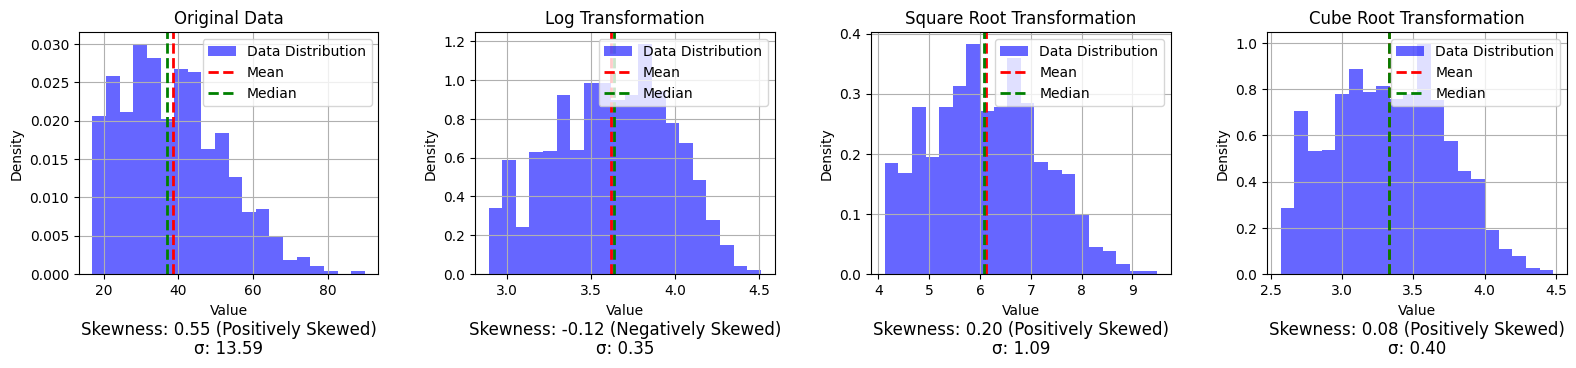

In [10]:
data = income_dataset.train_data["age"].values

# Create the subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Plot the data in the desired order
# Original Data
plt.sca(axes[0])
plot_distribution(data, title='Original Data', transform_skew_type=None)

# Log Transformation
plt.sca(axes[1])
plot_distribution(data, title='Log Transformation', transform_skew_type='log')

# Square Root Transformation
plt.sca(axes[2])
plot_distribution(data, title='Square Root Transformation', transform_skew_type='square_root')

# Cube Root Transformation
plt.sca(axes[3])
plot_distribution(data, title='Cube Root Transformation', transform_skew_type='cube_root')

# Adjust spacing
plt.tight_layout()

# Show the plots
plt.show()

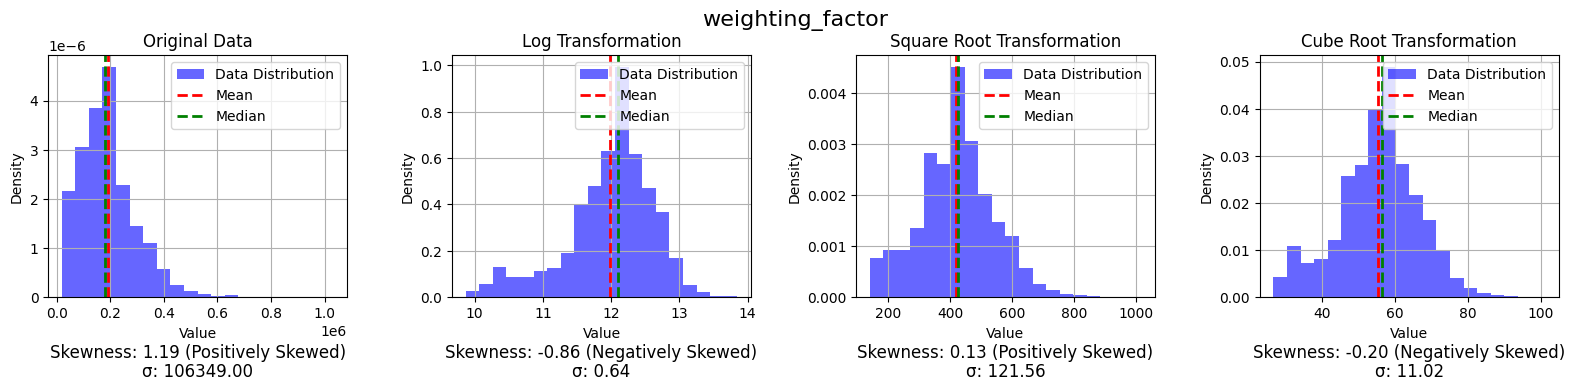

In [11]:
data = income_dataset.train_data["weighting_factor"].values

# Create the subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Plot the data in the desired order
# Original Data
plt.sca(axes[0])
plot_distribution(data, title='Original Data', transform_skew_type=None)

# Log Transformation
plt.sca(axes[1])
plot_distribution(data, title='Log Transformation', transform_skew_type='log')

# Square Root Transformation
plt.sca(axes[2])
plot_distribution(data, title='Square Root Transformation', transform_skew_type='square_root')

# Cube Root Transformation
plt.sca(axes[3])
plot_distribution(data, title='Cube Root Transformation', transform_skew_type='cube_root')

# Adjust spacing
plt.tight_layout()

fig.suptitle("weighting_factor", fontsize=16, y=1.02)

# Show the plots
plt.show()

From the above information, we can observe that the positive skewness linked with the feature attributes displayed can be altered into a stronger Gaussian distribution by applying any of the `log`, `square-root`, or `cube-root` transformations. Nevertheless, the latter transformations tend to exhibit more variability and higher deviation magnitude in comparison. Therefore, it would be preferable to opt for a `log` transformation when describing these features.

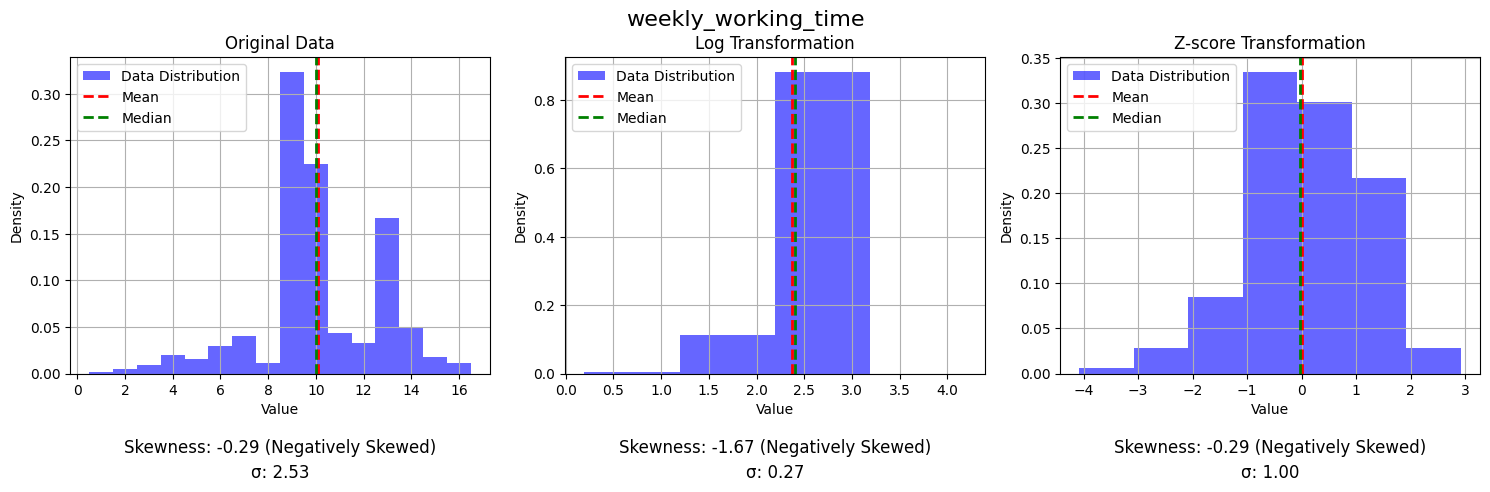

In [12]:
data = income_dataset.train_data["schooling_or_training_period"].values

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the data in the desired order
# Original Data
plt.sca(axs[0])
plot_distribution(data, title='Original Data', transform_skew_type=None, rank_based=True)

# Z-score Transformation
plt.sca(axs[1])
plot_distribution(data, title='Log Transformation', transform_skew_type='log', rank_based=True)

# Z-score Transformation
plt.sca(axs[2])
plot_distribution(data, title='Z-score Transformation', transform_skew_type='z_score', rank_based=True)

# Adjust spacing
plt.tight_layout()

fig.suptitle("weekly_working_time", fontsize=16, y=1.02)

# Show the plots
plt.show()

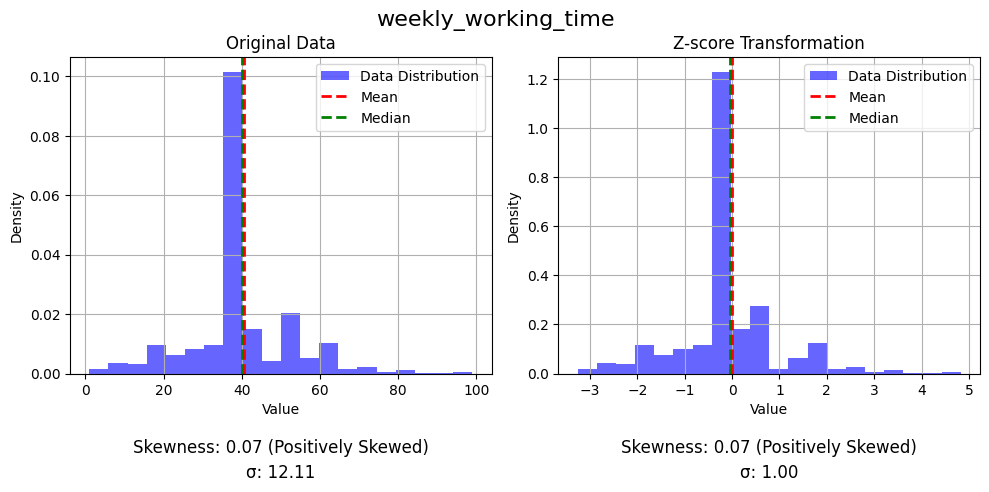

In [13]:
data = income_dataset.train_data["weekly_working_time"].values

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the data in the desired order
# Original Data
plt.sca(axs[0])
plot_distribution(data, title='Original Data', transform_skew_type=None)

# Z-score Transformation
plt.sca(axs[1])
plot_distribution(data, title='Z-score Transformation', transform_skew_type='z_score')

# Adjust spacing
plt.tight_layout()

fig.suptitle("weekly_working_time", fontsize=16, y=1.02)

# Show the plots
plt.show()

Both the `schooling or training period` and the `weekly working time` attributes exhibit a discrete distribution. In the case of the former, the time spent by individuals acquiring certain skills can be roughly estimated to be around 10 units, while the latter represents the average working time per individual, which can also be approximated to approximately 40 units based on the original data distribution graphs provided earlier. It's worth emphasizing that these distributions closely resemble a Gaussian distribution with some noticeable outliers. Therefore, it would be a reasonable approach to apply a `z-score` transformation to standardize the data and bring it to a more comparable scale.

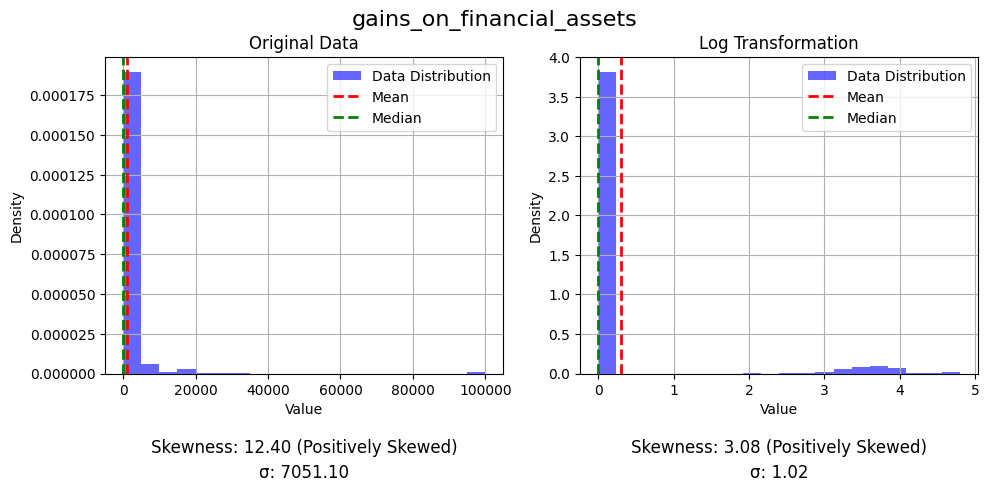

In [14]:
data = income_dataset.train_data["gains_on_financial_assets"].values

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the data in the desired order
# Original Data
plt.sca(axs[0])
plot_distribution(data, title='Original Data', transform_skew_type=None)

# Z-score Transformation
plt.sca(axs[1])
plot_distribution(data, title='Log Transformation', transform_skew_type='log', base_value=10)

# Adjust spacing
plt.tight_layout()

fig.suptitle("gains_on_financial_assets", fontsize=16, y=1.02)

# Show the plots
plt.show()

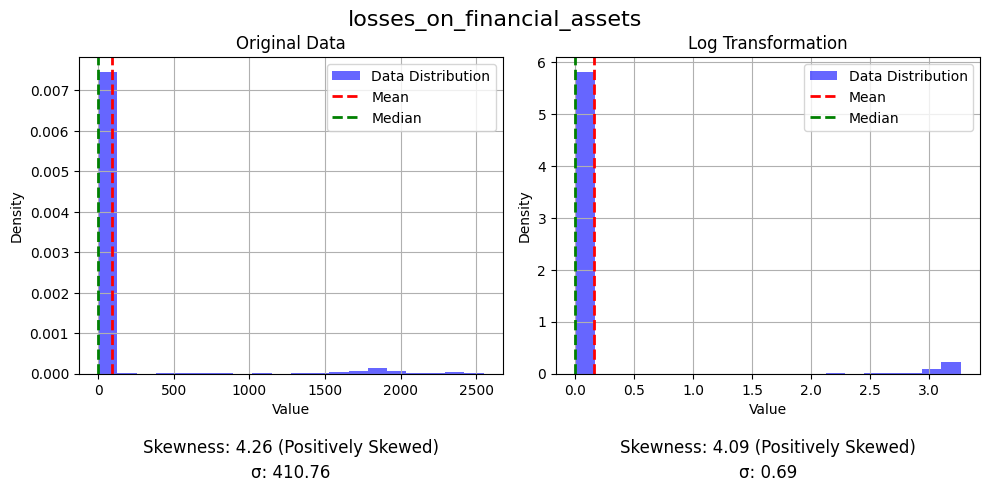

In [15]:
data = income_dataset.train_data["losses_on_financial_assets"].values

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the data in the desired order
# Original Data
plt.sca(axs[0])
plot_distribution(data, title='Original Data', transform_skew_type=None)

# Z-score Transformation
plt.sca(axs[1])
plot_distribution(data, title='Log Transformation', transform_skew_type='log', base_value=10)

# Adjust spacing
plt.tight_layout()

fig.suptitle("losses_on_financial_assets", fontsize=16, y=1.02)

# Show the plots
plt.show()

The data distribution for the feature attributes related to `gain on financial assets` and `losses on financial assets` displays significant irregularity, with the majority of recorded values being zero. However, there is considerable variation in the data, mainly concentrated in the range of 20K-100K for "profits" and 1500-2500 for "losses." This variation can serve as a valuable indicator since, in general terms, profit contributes positively to a person's income, while losses have the opposite effect.

To address the issue of extensive sparsity in these two attributes, an ideal choice would be to apply a logarithmic transformation with a base value of approximately <u>10</u>. This transformation, using a logarithmic scale, introduces a non-linear adjustment to exponential values, thereby reducing the proportional differences within the data.

----
`Categorical Data Attributes`

In [16]:
categorical_columns = income_dataset.train_data.select_dtypes(include=['object']).columns.tolist()
print("Available categorical columns: ", categorical_columns[:-1])

Available categorical columns:  ['employment_type', 'level_of_education', 'marital_status', 'employment_area', 'partnership', 'ethnicity', 'gender', 'country_of_birth']


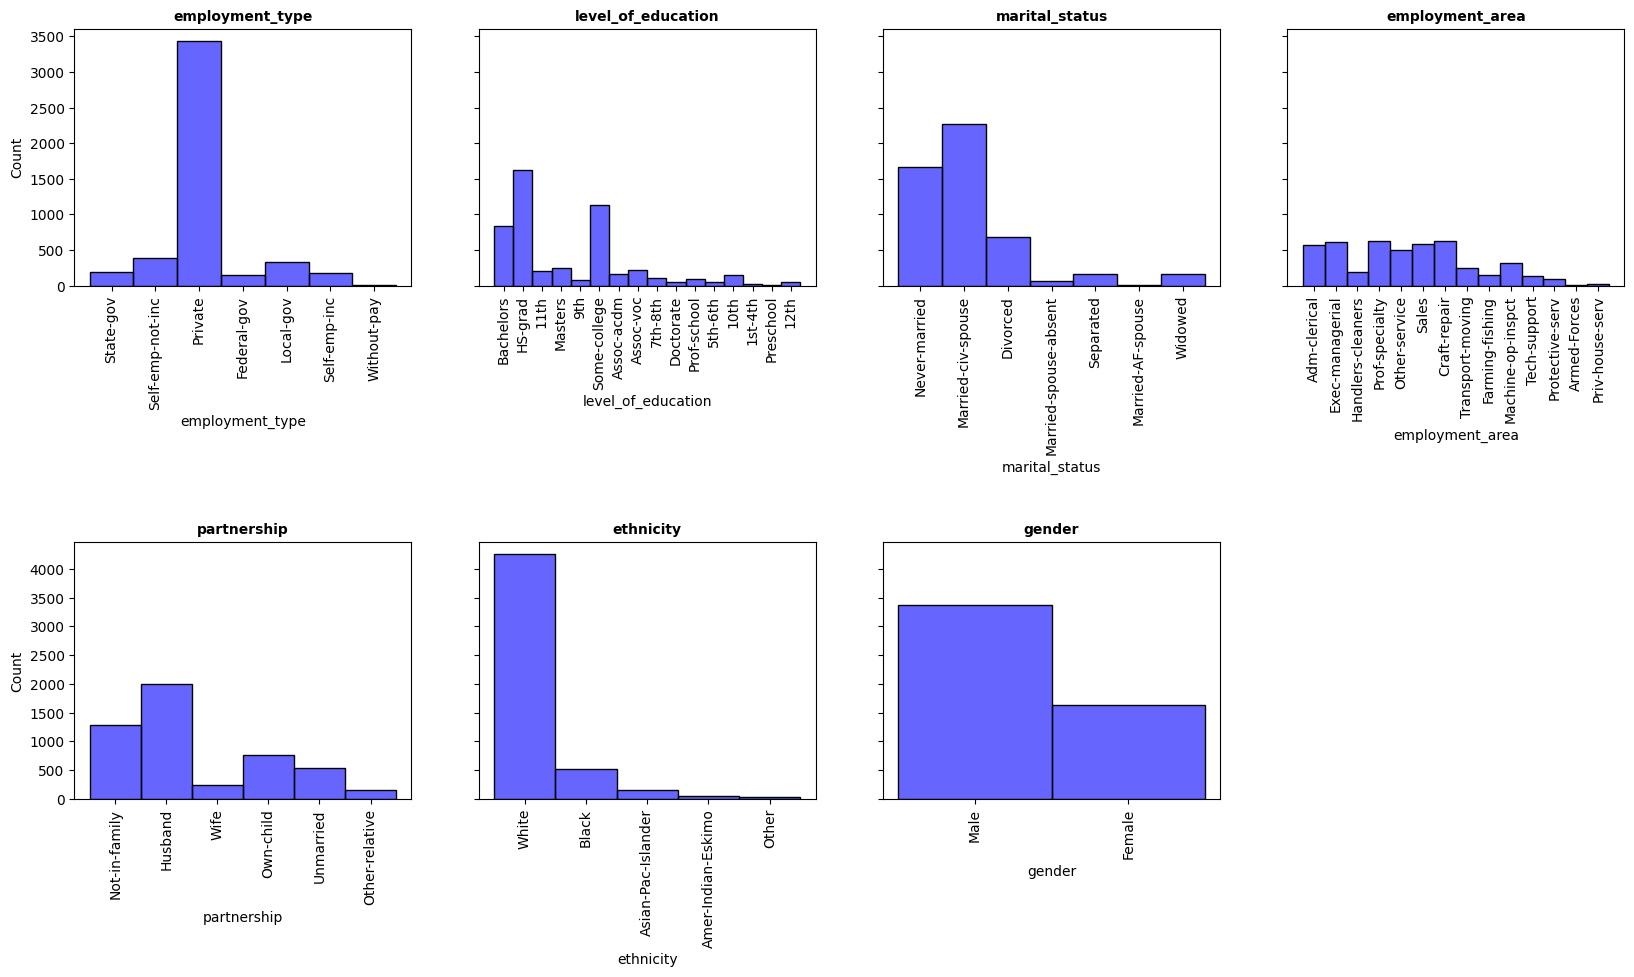

In [17]:
categorical_columns = categorical_columns[:-2]

fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharey='row', gridspec_kw={'hspace': 1.0})

for i, column in enumerate(categorical_columns[:7]):
    row_index, col_index = divmod(i, 4)
    ax = axes[row_index, col_index]

    sns.histplot(income_dataset.train_data[column], ax=ax, color="b", alpha=0.6)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(column, fontsize=10, fontweight="bold")

fig.delaxes(axes[1, 3])
plt.show()

The feature attribute `country of birth` has a highly imbalanced categorical data formulation, with the majority (89%) belonging to the category `United-States`.

In [18]:
print(income_dataset.train_data['country_of_birth'].unique())

['United-States' 'Cuba' 'Jamaica' 'India' nan 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' 'Canada' 'Germany' 'Iran'
 'Philippines' 'Italy' 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador'
 'Laos' 'Taiwan' 'Haiti' 'Portugal' 'Dominican-Republic' 'El-Salvador'
 'France' 'Guatemala' 'China' 'Japan' 'Yugoslavia' 'Peru'
 'Outlying-US(Guam-USVI-etc)' 'Scotland' 'Trinadad&Tobago' 'Greece'
 'Nicaragua' 'Vietnam' 'Hong' 'Ireland']


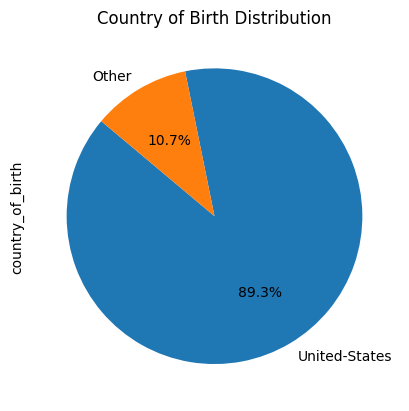

In [19]:
cob_data = income_dataset.train_data['country_of_birth'].apply(lambda x: 'United-States' if x == 'United-States' else 'Other')

cob_data.value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Country of Birth Distribution')
plt.show()

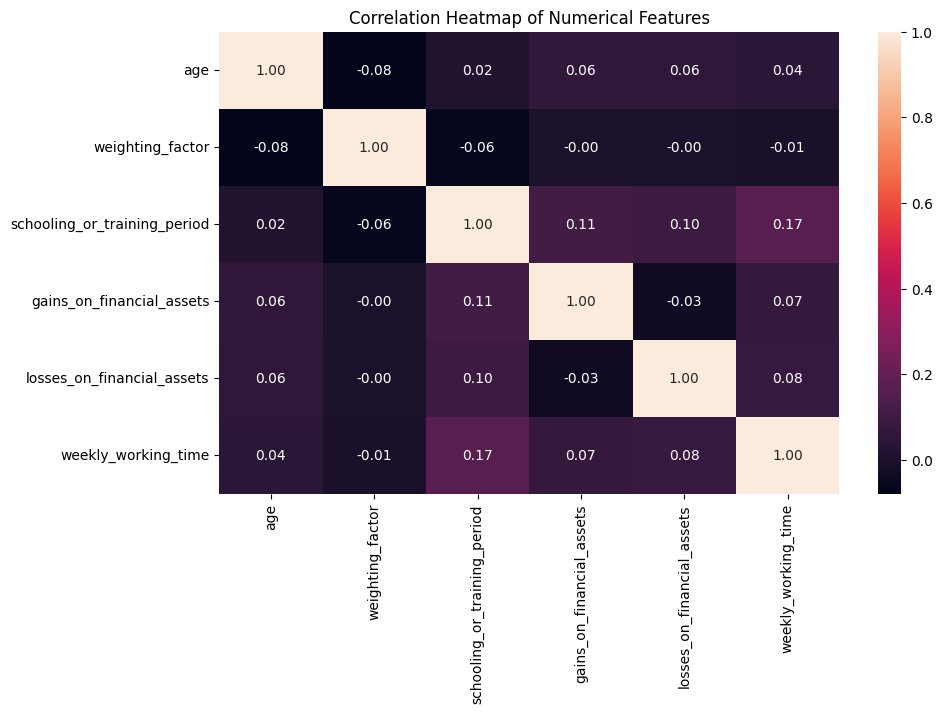

In [20]:
plt.figure(figsize=(10, 6))
sns.heatmap(income_dataset.train_data.corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [21]:
income_dataset.archive_classwise_label_encodings()
income_dataset.encode_data()
income_dataset.process_and_split_data()

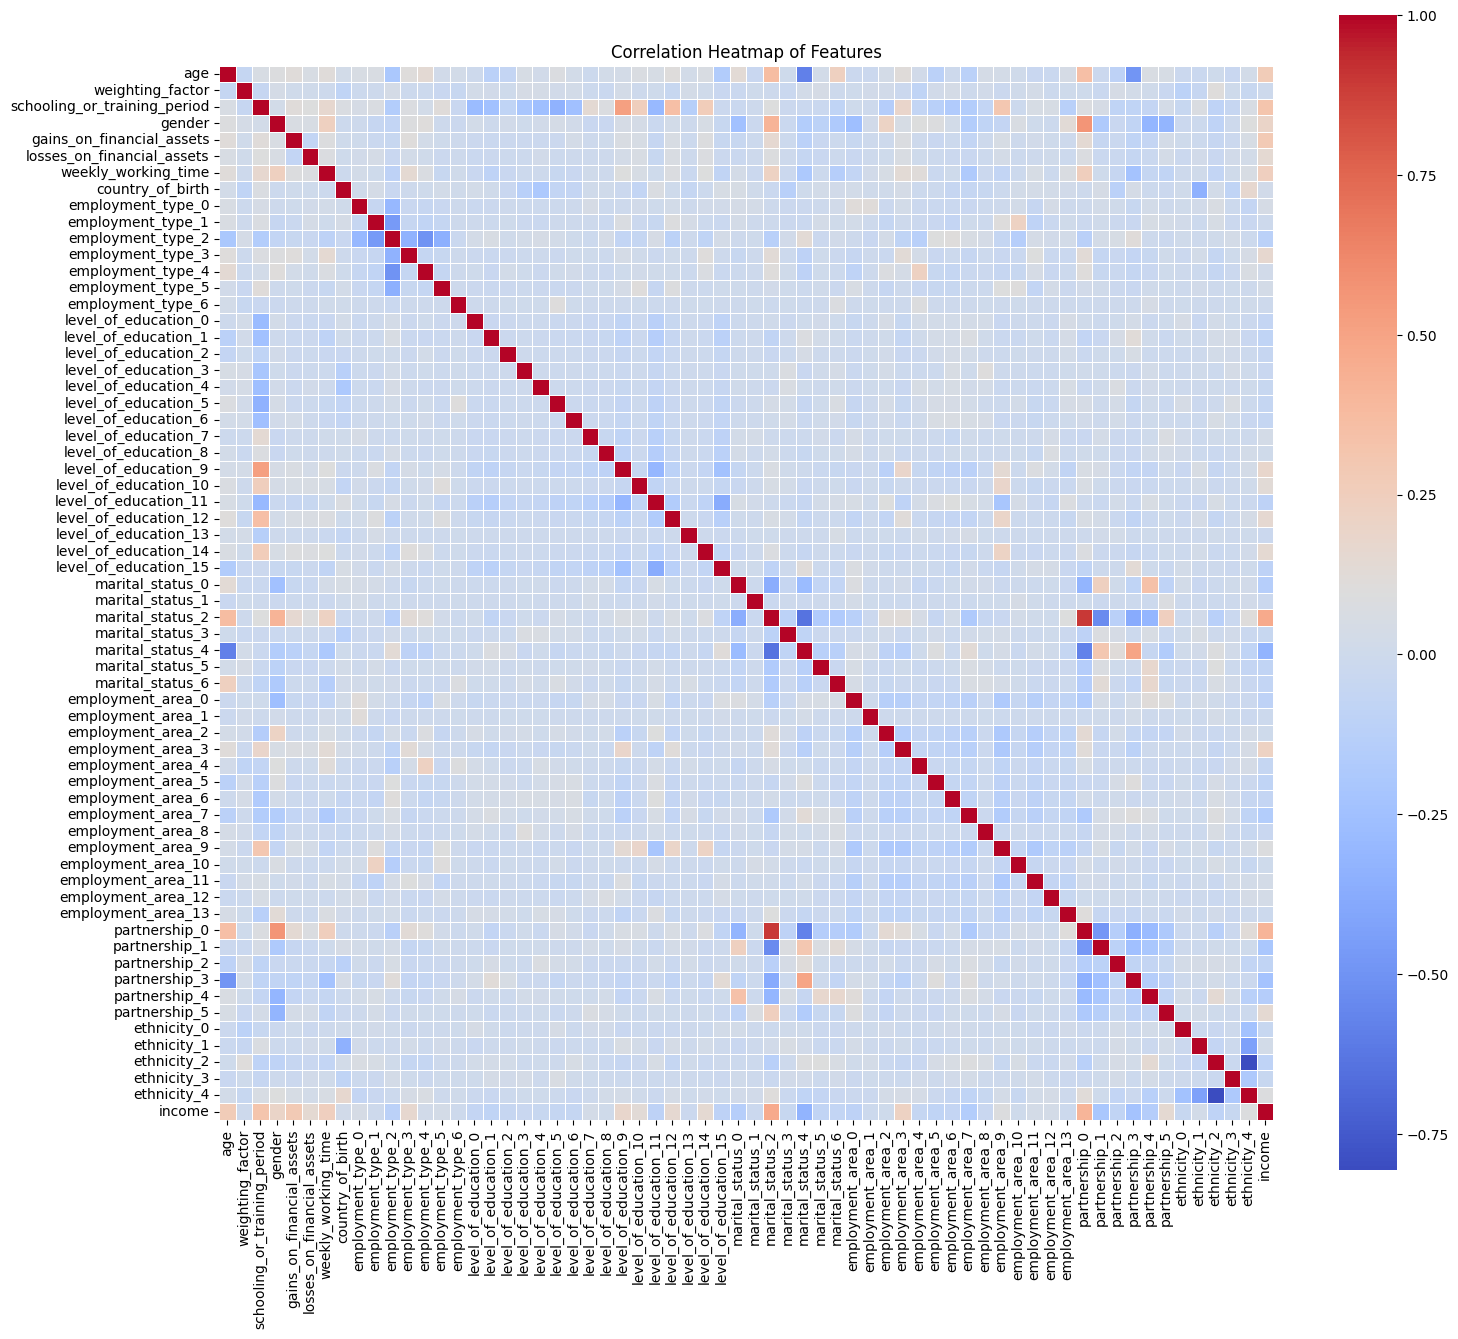

In [22]:
corr_matrix = income_dataset.train_data.corr()

plt.figure(figsize=(17, 15))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=False,
    fmt=".2f",
    square=True,
    linewidths=0.5
)

plt.title('Correlation Heatmap of Features')
plt.xticks(rotation=90)
plt.show()

---
`Income Groups`

From the distribution of the target labels, we can deduce that the data exhibits a significant imbalance, with the majority of instances falling into the category of <=50K. This observation aligns with real-world data, as there typically exists a substantial gap between lower and higher income groups.

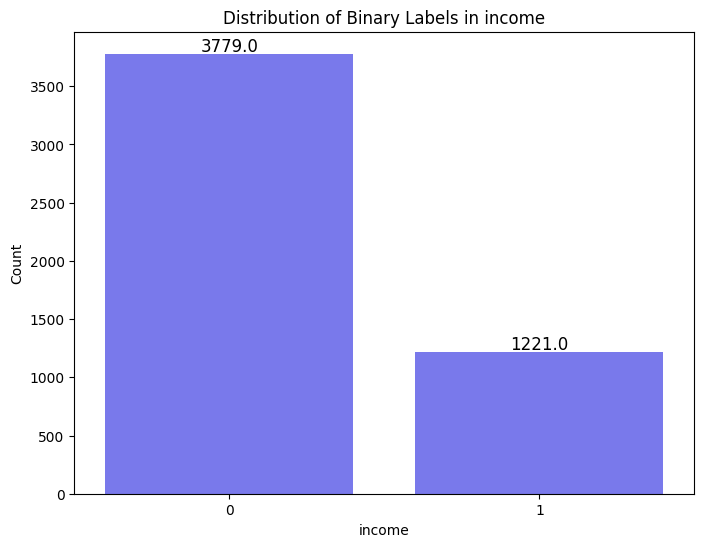

In [23]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=income_dataset.train_data, x="income", color='blue', alpha=0.6)
plt.xlabel("income")
plt.ylabel("Count")
plt.title("Distribution of Binary Labels in " + "income")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

-----
#### `Modeling`

In [24]:
y_pred_prob_tracker = {} # track all the model output probabilities for `test` split of data

-----
##### `Decision Tree & Ensemble Methods`

##### **Decision Tree Classifier**

In [25]:
dt_config = load_from_yaml("./configurations/decision_tree_config.yaml")
dt_model = ClassificationModel(config=dt_config)
dt_model.train_model()
_ = dt_model.get_accuracy_score()
_ = dt_model.get_f1_score()

y_pred_prob_tracker["decision_tree"] = dt_model.generate_predictions(probs=True)

loading data from .yaml file @ ./configurations/decision_tree_config.yaml
Accuracy Score: 0.853
F1 Score: 0.6388206388206388


In [26]:
%%capture
plt.figure(figsize=(40, 35))

feature_names = dt_model.income_dataset.train_data.columns.tolist()[:-1]
class_names = dt_model.income_dataset.encoding_state_dict["income"].classes_.tolist()

tree.plot_tree(dt_model.clf,
               filled=True,
               feature_names=feature_names,
               class_names=class_names,
               fontsize=12)

plt.show()

##### **Bagging w/ Decision Tree Classifier**

In [27]:
ens_dt_config = load_from_yaml("./configurations/bagging_decision_tree_config.yaml")
ens_dt_model = ClassificationModel(config=ens_dt_config)
ens_dt_model.train_model()
_ = ens_dt_model.get_accuracy_score()
_ = ens_dt_model.get_f1_score()

y_pred_prob_tracker["bagging_decision_tree"] = ens_dt_model.generate_predictions(probs=True)

loading data from .yaml file @ ./configurations/bagging_decision_tree_config.yaml
Accuracy Score: 0.858
F1 Score: 0.6519607843137254


##### **Random Forest Classifier**

In [28]:
# GridSearchCV
rf_config = load_from_yaml("./configurations/random_forest_config.yaml")
rf_dataset = IncomeDataset(rf_config)
param_grid = {
    "n_estimators": [1, 50, 100, 150, 200, 250],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [2, 4, 8, 12],
    "min_samples_split": [5, 10, 15, 20, 25, 30],
    "min_samples_leaf": [2, 5, 10, 15, 20, 25, 30],
    "max_features": ["auto", "sqrt", "log2"],
    "bootstrap": [True, False]
}
rf_model = RandomForestClassifier()
rf_grid_search = GridSearchCV(estimator=rf_model,
                              param_grid=param_grid,
                              cv=5,
                              n_jobs=-1)
# rf_grid_search.fit(rf_dataset.X_train, rf_dataset.y_train)
# print(f"Optimal parameter setting: {rf_grid_search.best_params_}")

loading data from .yaml file @ ./configurations/random_forest_config.yaml


Note: After extracting the optimal hyperparameter configuration, the original *random_forest_config.yaml* file should be updated accordingly.

In [29]:
# final model
rf_opt_config = load_from_yaml("./configurations/random_forest_config.yaml")
rf_opt_model = ClassificationModel(rf_opt_config)
rf_opt_model.train_model()
_ = rf_opt_model.get_accuracy_score()
_ = rf_opt_model.get_f1_score()

y_pred_prob_tracker["random_forest"] = rf_opt_model.generate_predictions(probs=True)

loading data from .yaml file @ ./configurations/random_forest_config.yaml
Accuracy Score: 0.863
F1 Score: 0.668280871670702


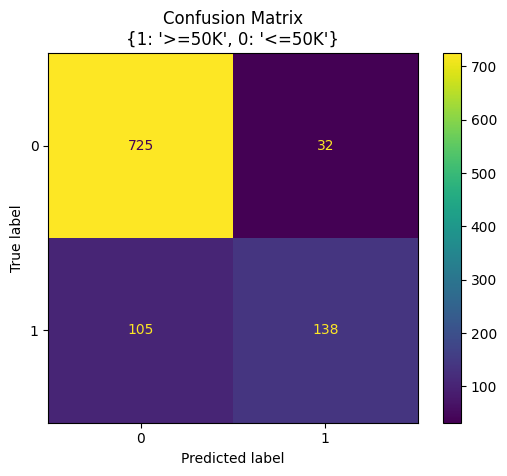

In [30]:
rf_opt_model.show_confusion_plot()

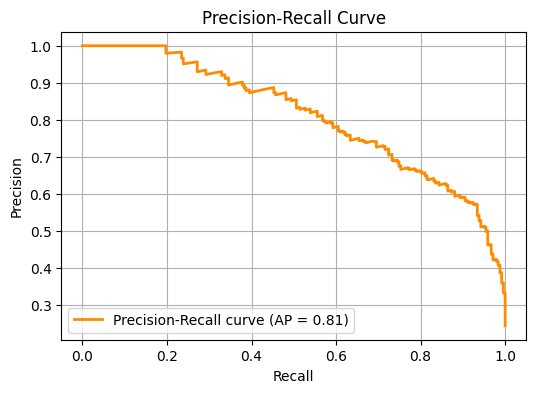

In [31]:
rf_opt_model.show_pr_curve_plot()

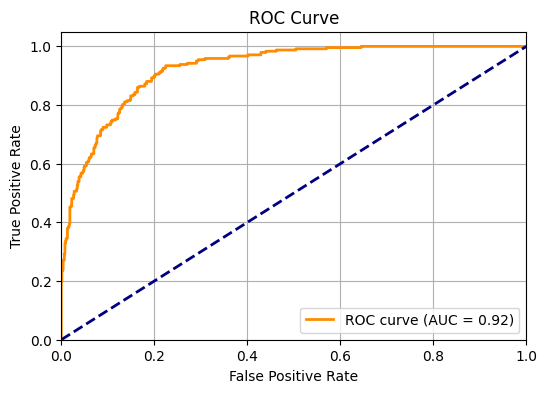

In [32]:
rf_opt_model.show_ROC_curve_plot()

-----
##### **Logistic Regression Classifier**

In [33]:
# GridSearchCV
lr_config = load_from_yaml("./configurations/logistic_regression_config.yaml")
lr_dataset = IncomeDataset(config=lr_config)
param_grid = {
    "penalty": ["l1", "l2", "elasticnet"],
    "max_iter": [100, 200, 300, 400],
}
lr_model = LogisticRegression()
lr_grid_search = GridSearchCV(estimator=lr_model,
                              param_grid=param_grid,
                              cv=5,
                              n_jobs=-1)
# lr_grid_search.fit(lr_dataset.X_train, lr_dataset.y_train)
# print(f"Optimal parameter setting: {lr_grid_search.best_params_}")

loading data from .yaml file @ ./configurations/logistic_regression_config.yaml


Note: After extracting the optimal hyperparameter configuration, the original *logistic_regression_config.yaml* file should be updated accordingly.

In [34]:
# final model
lr_opt_config = load_from_yaml("./configurations/logistic_regression_config.yaml")
lr_opt_model = ClassificationModel(lr_opt_config)
lr_opt_model.train_model()
_ = lr_opt_model.get_accuracy_score()
_ = lr_opt_model.get_f1_score()

y_pred_prob_tracker["logistic_regression"] = lr_opt_model.generate_predictions(probs=True)

loading data from .yaml file @ ./configurations/logistic_regression_config.yaml
Accuracy Score: 0.857
F1 Score: 0.6537530266343825


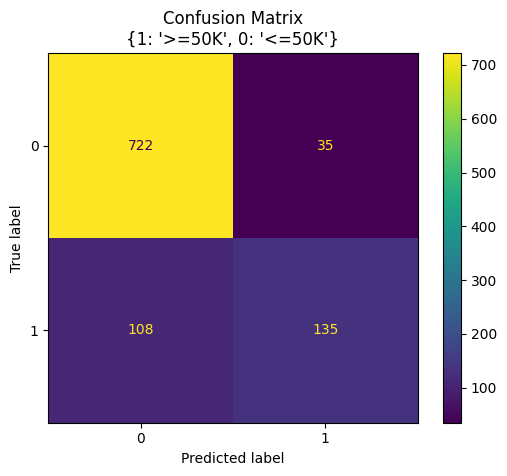

In [35]:
lr_opt_model.show_confusion_plot()

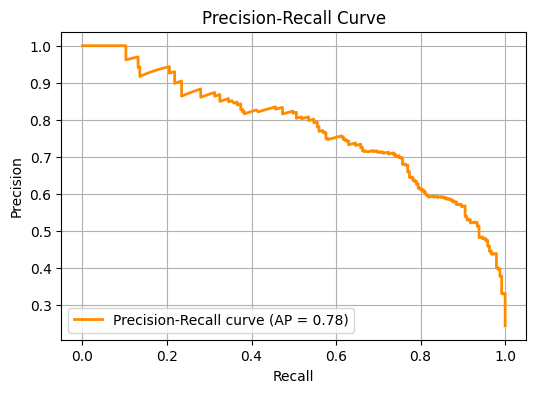

In [36]:
lr_opt_model.show_pr_curve_plot()

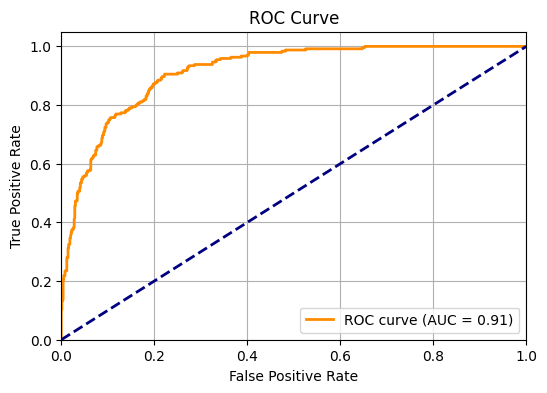

In [37]:
lr_opt_model.show_ROC_curve_plot()

------
##### Overall Comparison

In [38]:
test_config = load_from_yaml("./configurations/config.yaml")
income_dataset = IncomeDataset(config=test_config)
y_true = income_dataset.y_test

loading data from .yaml file @ ./configurations/config.yaml


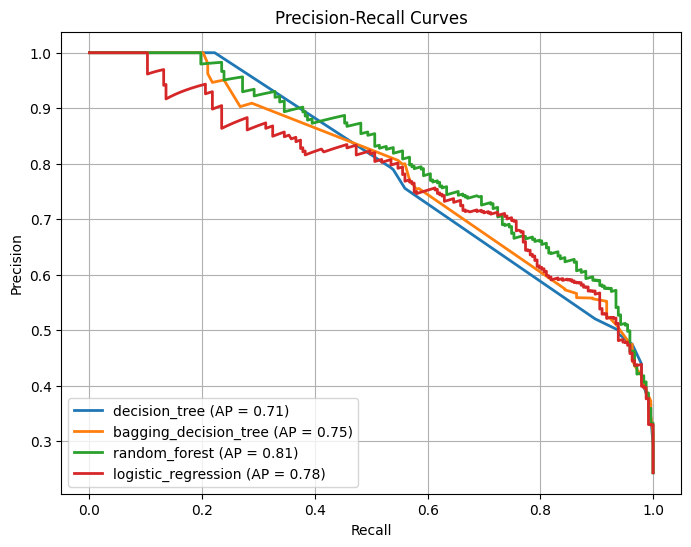

In [39]:
plt.figure(figsize=(8, 6))
for model_name, y_pred_prob in y_pred_prob_tracker.items():
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    average_precision = average_precision_score(y_true, y_pred_prob)
    plt.plot(recall, precision, lw=2, label=f'{model_name} (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In general, the performance of all the tree-based models and the linear classification model is quite similar. Notably, the `random-forest` model exhibits a better average precision compared to the `logistic regression` model. This improved performance of the `random-forest` model can be attributed to its training approach, which involves creating multiple models using both bootstrapped and feature-sampled data. This strategy allows the `random-forest` model to effectively mitigate certain shortcomings introduced by varying features, a limitation seen in the `bagging decision-tree` model.

-------
##### `Neural-Networks` (Additional Experiments)


1.  **Baseline Configuration**
    *   **Optimizer**: SGD (Stochastic Gradient Descent)
    *   **Parameter Initialization***: Glorot-Uniform (default)
    *   **Num Hidden Layers**: 1

2.  **Model Configuration 2:**
    *   **Optimizer**: Adam
    *   **Parameter Initialization***: Zeros
    *   **Num Hidden Layers**: 2
    *   **Mini-Batch**: True (default)

3.  **Model Configuration 3:**
    *   **Optimizer**: Adam
    *   **Parameter Initialization***: Glorot-Uniform (default)
    *   **Num Hidden Layers**: 2
    *   **Mini-Batch**: True (default)

4.  **Model Configuration 4:**
    *   **Optimizer**: Adam
    *   **Parameter Initialization***: Glorot-Normal (Xavier-Normal)
    *   **Num Hidden Layers**: 2
    *   **Mini-Batch**: True (default)

5.  **Model Configuration 5:**
    *   **Optimizer**: RMSProp
    *   **Parameter Initialization***: Glorot-Uniform (default)
    *   **Num Hidden Layers**: 2
    *   **Mini-Batch**: True (default)

**Common Configuration attributes**:
*   **Hidden Activation**: ReLU
*   **Output Activation**: Sigmoid (binary classification)
*   **Loss Function**: Binary CrossEntropy Loss
*   **Metrics**: Accuracy, Precision, Recall
*   **Num Epochs**: 20
*   **Dropout**: 0.2
-----


In [40]:
nn_config = load_from_yaml("./configurations/neural_network_config.yaml")
income_dataset = IncomeDataset(nn_config)

loading data from .yaml file @ ./configurations/neural_network_config.yaml


In [41]:
X_train, y_train = income_dataset.X_train, income_dataset.y_train
X_test, y_test = income_dataset.X_test, income_dataset.y_test
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (4000, 63), y_train: (4000,)
X_test: (1000, 63), y_test: (1000,)


In [42]:
input_shape = (X_train.shape[1],)

In [43]:
metrics = ["accuracy", Precision(name="precision"), Recall(name="recall")]

In [44]:
%%capture
# baseline
model = keras.Sequential()
model.add(keras.layers.Dense(32, activation="relu", input_shape=input_shape))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation="relu", kernel_initializer=GlorotUniform))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation="sigmoid", kernel_initializer=GlorotUniform))
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=metrics)
model.summary()

# train model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

In [45]:
# evaluation
eval_scores = model.evaluate(X_test, y_test)
print(f"Evaluation Scores:\nLoss: {eval_scores[0]:.2f} | Accuracy: {eval_scores[1]:.2f} | Precision: {eval_scores[2]:.2f} | Recall: {eval_scores[3]:.2f}")

32/32 [==============================] - 0s 2ms/step - loss: 0.3140 - accuracy: 0.8470 - precision: 0.7473 - recall: 0.5597
Evaluation Scores:
Loss: 0.31 | Accuracy: 0.85 | Precision: 0.75 | Recall: 0.56


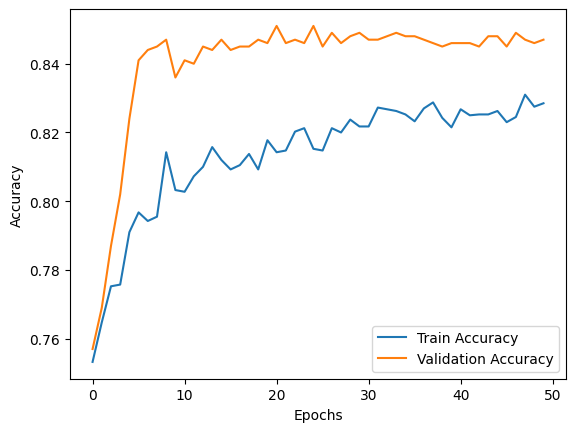

In [46]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

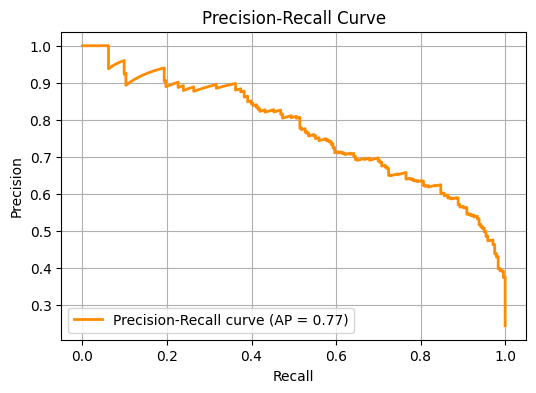

In [47]:
out = plot_precision_recall_curve(y_true=y_test,
                                  y_pred_prob=model.predict(X_test, verbose=0))
plt.show()

In [48]:
%%capture
# model_2
model = keras.Sequential()
model.add(keras.layers.Dense(32, activation="relu", input_shape=input_shape))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation="relu", kernel_initializer=Zeros))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation="sigmoid", kernel_initializer=Zeros))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=metrics)
model.summary()

# train model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

In [49]:
# evaluation
eval_scores = model.evaluate(X_test, y_test)
print(f"Evaluation Scores:\nLoss: {eval_scores[0]:.2f} | Accuracy: {eval_scores[1]:.2f} | Precision: {eval_scores[2]:.2f} | Recall: {eval_scores[3]:.2f}")

32/32 [==============================] - 0s 3ms/step - loss: 0.5545 - accuracy: 0.7570 - precision: 0.0000e+00 - recall: 0.0000e+00
Evaluation Scores:
Loss: 0.55 | Accuracy: 0.76 | Precision: 0.00 | Recall: 0.00


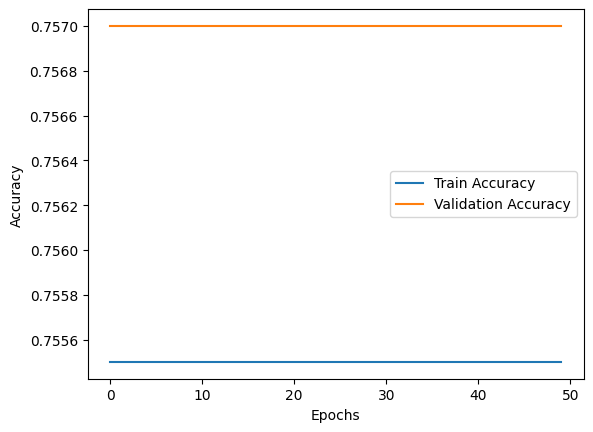

In [50]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

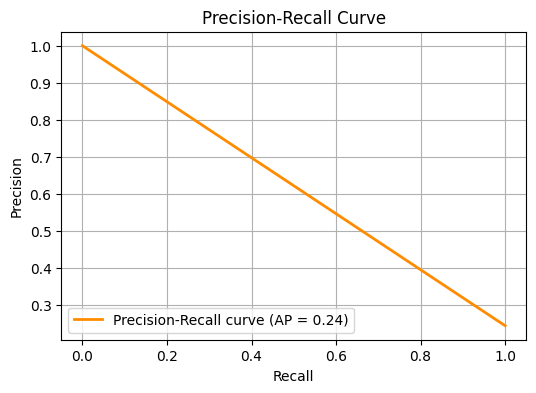

In [51]:
out = plot_precision_recall_curve(y_true=y_test,
                                  y_pred_prob=model.predict(X_test, verbose=0))
plt.show()

In [52]:
%%capture
# model_3
model = keras.Sequential()
model.add(keras.layers.Dense(32, activation="relu", input_shape=input_shape))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation="relu", kernel_initializer=GlorotUniform))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(8, activation="relu", kernel_initializer=GlorotUniform))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation="sigmoid", kernel_initializer=GlorotUniform))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=metrics)
model.summary()

# train model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

In [53]:
# evaluation
eval_scores = model.evaluate(X_test, y_test)
print(f"Evaluation Scores:\nLoss: {eval_scores[0]:.2f} | Accuracy: {eval_scores[1]:.2f} | Precision: {eval_scores[2]:.2f} | Recall: {eval_scores[3]:.2f}")

32/32 [==============================] - 0s 2ms/step - loss: 0.3437 - accuracy: 0.8430 - precision: 0.7067 - recall: 0.6049
Evaluation Scores:
Loss: 0.34 | Accuracy: 0.84 | Precision: 0.71 | Recall: 0.60


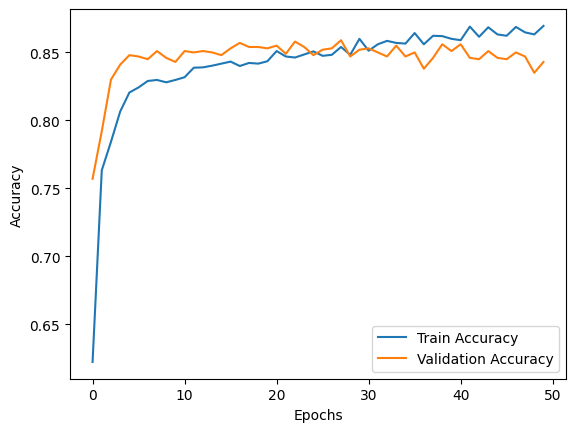

In [54]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

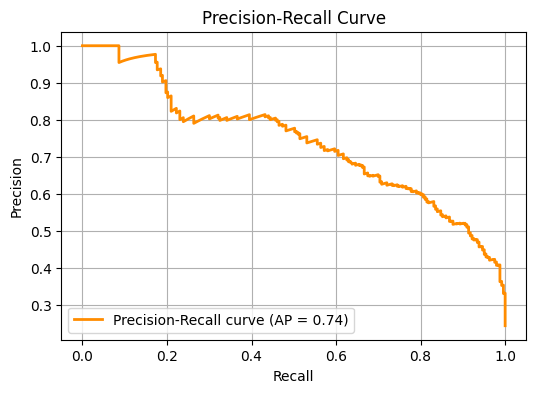

In [55]:
out = plot_precision_recall_curve(y_true=y_test,
                                  y_pred_prob=model.predict(X_test, verbose=0))
plt.show()

In [56]:
%%capture
# model_4
model = keras.Sequential()
model.add(keras.layers.Dense(32, activation="relu", input_shape=input_shape))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation="relu", kernel_initializer=GlorotNormal))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(8, activation="relu", kernel_initializer=GlorotNormal))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation="sigmoid", kernel_initializer=GlorotNormal))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=metrics)
model.summary()

# train model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

In [57]:
# evaluation
eval_scores = model.evaluate(X_test, y_test)
print(f"Evaluation Scores:\nLoss: {eval_scores[0]:.2f} | Accuracy: {eval_scores[1]:.2f} | Precision: {eval_scores[2]:.2f} | Recall: {eval_scores[3]:.2f}")

32/32 [==============================] - 0s 2ms/step - loss: 0.3411 - accuracy: 0.8430 - precision: 0.7471 - recall: 0.5350
Evaluation Scores:
Loss: 0.34 | Accuracy: 0.84 | Precision: 0.75 | Recall: 0.53


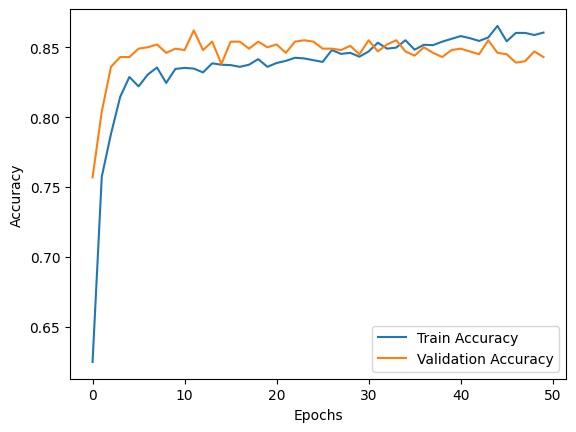

In [58]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

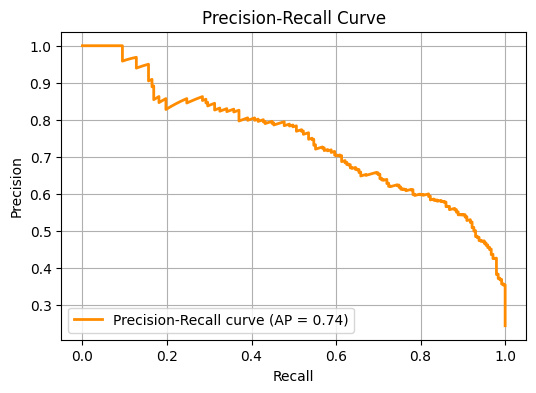

In [59]:
out = plot_precision_recall_curve(y_true=y_test,
                                  y_pred_prob=model.predict(X_test, verbose=0))
plt.show()

In [60]:
%%capture
# model_5
model = keras.Sequential()
model.add(keras.layers.Dense(32, activation="relu", input_shape=input_shape))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation="relu", kernel_initializer=GlorotUniform))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(8, activation="relu", kernel_initializer=GlorotUniform))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation="sigmoid", kernel_initializer=GlorotUniform))
model.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=metrics)
model.summary()

# train model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

In [61]:
# evaluation
eval_scores = model.evaluate(X_test, y_test)
print(f"Evaluation Scores:\nLoss: {eval_scores[0]:.2f} | Accuracy: {eval_scores[1]:.2f} | Precision: {eval_scores[2]:.2f} | Recall: {eval_scores[3]:.2f}")

32/32 [==============================] - 0s 2ms/step - loss: 0.3306 - accuracy: 0.8460 - precision: 0.7697 - recall: 0.5226
Evaluation Scores:
Loss: 0.33 | Accuracy: 0.85 | Precision: 0.77 | Recall: 0.52


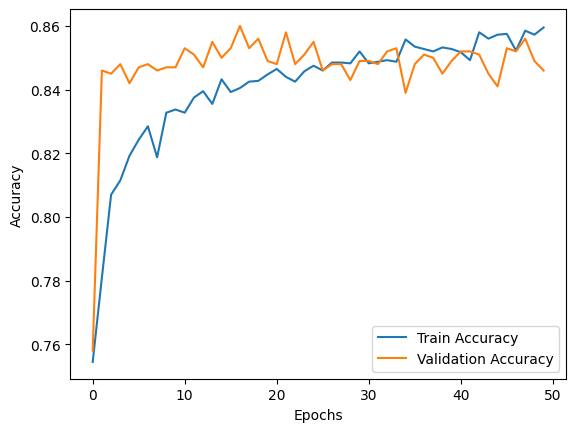

In [62]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

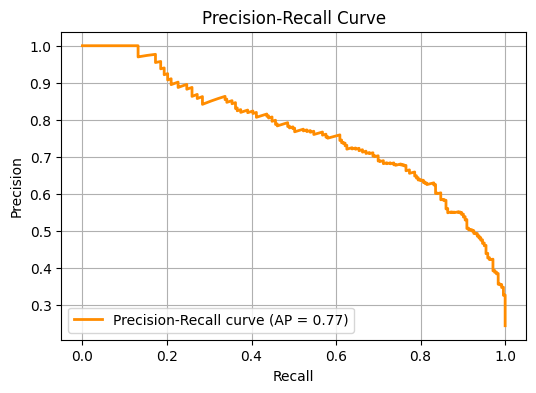

In [63]:
out = plot_precision_recall_curve(y_true=y_test,
                                  y_pred_prob=model.predict(X_test, verbose=0))
plt.show()